In [ ]:
import torch 
import torchvision
from torchvision import datasets
import numpy as np
import time
import numpy
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.datasets import MNIST
import librosa
from scipy import signal
import matplotlib.pyplot as plt
import pickle
import collections
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class MNIST_GPU(MNIST):
  def __init__(self, *args, **kwargs):
    super(MNIST_GPU, self).__init__(*args, **kwargs)

    # Convert to tensor and send to GPU
    self.data = self.data.to(device)
    self.targets = self.targets.to(device)

    # # Scale the data to [0,1]
    self.data = self.data.unsqueeze(1).float().div(255)


  def __getitem__(self, idx):
    return self.data[idx], self.targets[idx]


  def __len__(self):
        return len(self.data)

In [ ]:
mnist_train= MNIST_GPU("mnist",
      train=True,
      download=True)

mnist_test=MNIST_GPU("mnist",
      train=False,
      download=True,
      )

## Training_Data and Testing_Data


In [ ]:
train_data=mnist_train.data
test_data=mnist_test.data

## Converting Training and Test_Data into numpy array

In [ ]:
train_data_final=torch.squeeze(train_data).cpu().numpy()
test_data_final=torch.squeeze(test_data).cpu().numpy()

In [ ]:
test_data_targets=mnist_test.targets
test_data1=test_data_targets[0:500].cpu().numpy()

## Finding the twenty images of each class and label from test_data

In [ ]:
index_0=np.where(test_data1 == 0)[0][0:20]
index_1=np.where(test_data1 == 1)[0][0:20]
index_2=np.where(test_data1 == 2)[0][0:20]
index_3=np.where(test_data1 == 3)[0][0:20]
index_4=np.where(test_data1 == 4)[0][0:20]
index_5=np.where(test_data1 == 5)[0][0:20]
index_6=np.where(test_data1 == 6)[0][0:20]
index_7=np.where(test_data1 == 7)[0][0:20]
index_8=np.where(test_data1 == 8)[0][0:20]
index_9=np.where(test_data1 == 9)[0][0:20]

## Finding the Indexes of the labels

In [ ]:
test_indexes_in_the_order=np.hstack((index_0,index_1,index_2,index_3,index_4,index_5,index_6,index_7,index_8,index_9))

### Getting the image vector for the test_data

In [ ]:
test_Images_to_be_displayed= test_data_final[test_indexes_in_the_order]

## Plot of Input Images

<function matplotlib.pyplot.show>

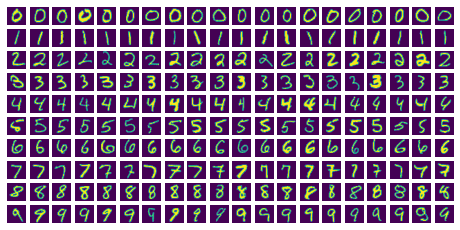

In [ ]:
n_images = 200
fig = plt.figure(figsize=(8,8))
for i in range(n_images):
  fig.add_subplot(n_images//10,20,i+1)
  plt.axis('off')
  plt.imshow(test_Images_to_be_displayed[i])
plt.show

In [ ]:
def func_data(train_data2):
  list2=[]
  for i in range(len(train_data2)):
    data_point= train_data2[i]
    list1=[]
    for j in range(4):
      row_start=j*7
      row_end=(j+1)*7
      for k in range(4):
        column_start=k*7
        column_end= (k+1)*7
        new_data=data_point[row_start:row_end,column_start:column_end].flatten()
        list1.append(new_data)
    list2.append(list1)
  
  return list2

In [ ]:
train_data_final1 = np.array(func_data(train_data_final))

In [ ]:
test_data_final1 =  np.array(func_data(test_data_final))

In [ ]:
np.shape(test_data_final1)

(10000, 16, 49)

In [ ]:
def data_conversion(train_data_final2):
  loading_train_data1=[]
  for i in range(len(train_data_final2)):
    loading_train_data1.append([train_data_final2[i][0:15],train_data_final2[i][1:16]])
  return loading_train_data1

In [ ]:
loading_train_data= data_conversion(train_data_final1)
loading_valid_data=data_conversion(test_data_final1)

In [ ]:
np.shape(loading_train_data)

(60000, 2, 15, 49)

In [ ]:
train_loader1 = torch.utils.data.DataLoader(dataset=loading_train_data, 
                                           batch_size=500, 
                                           shuffle=False)
test_loader1=torch.utils.data.DataLoader(dataset=loading_valid_data, 
                                           batch_size=10000, 
                                           shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout=0.2)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.act=nn.ReLU()

    def forward(self, x, prev_state):
        # Initialize hidden state with zeros
        

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, state = self.lstm(x,prev_state)

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out)
        # out.size() --> 100, 10
        return out , state
        
    def init_state(self, x):
        return (torch.zeros(self.layer_dim, x.size(0), self.hidden_dim),
                torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

In [ ]:
input_dim = 49
hidden_dim = 512
layer_dim = 3
output_dim = 49

In [ ]:
model_lstm=LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).cuda()

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

In [ ]:
def accuracy(model,validloader1):

  with torch.no_grad():
    for i ,(test_X,test_Y) in enumerate(validloader1):
      criterion=nn.MSELoss()
      labels = test_Y.float().cuda()
      state_h, state_c = model.init_state(test_X)
      outputs,new_state= model(test_X.float().cuda(),(state_h.cuda(),state_c.cuda()))
      loss=criterion(outputs.cuda(),labels.cuda())
  
  return loss.item()

In [ ]:
num_epochs=30

In [ ]:
new_loss=0
plot_loss=[]
iter = 0
validation_loss=[]
for epoch in range(num_epochs):
    new_loss=0
    for j ,(outputs,labels) in enumerate(train_loader1):
        model_lstm.train()
        outputs1= outputs.float()
        labels1= labels.float()
        state_h, state_c = model_lstm.init_state(outputs1)
        optimizer.zero_grad()
        outputs2,(state_h,state_c)=model_lstm(outputs1.cuda(),(state_h.cuda(),state_c.cuda()))
        loss = criterion(outputs2.cuda(),labels1.cuda()).cuda()

        state_h = state_h.detach()
        state_c = state_c.detach()

        loss.backward()
        optimizer.step()
        new_loss=new_loss+loss.item()
  
    plot_loss.append(new_loss/120)
    model_lstm.eval()
    validt= accuracy(model_lstm,test_loader1)
    validation_loss.append(validt)
    print('Iteration: {}. Trainining_Loss: {}. Validation_loss: {}'.format(epoch, new_loss/120,validt))

Iteration: 0. Trainining_Loss: 0.08734974783534805. Validation_loss: 0.06499798595905304
Iteration: 1. Trainining_Loss: 0.0534891870804131. Validation_loss: 0.04474995657801628
Iteration: 2. Trainining_Loss: 0.04230996435508132. Validation_loss: 0.03811372444033623
Iteration: 3. Trainining_Loss: 0.03751317846278349. Validation_loss: 0.03499188274145126
Iteration: 4. Trainining_Loss: 0.03499180329963565. Validation_loss: 0.03321786969900131
Iteration: 5. Trainining_Loss: 0.03346864058015247. Validation_loss: 0.032049860805273056
Iteration: 6. Trainining_Loss: 0.03234497040199737. Validation_loss: 0.031183505430817604
Iteration: 7. Trainining_Loss: 0.03151614451780915. Validation_loss: 0.03060913272202015
Iteration: 8. Trainining_Loss: 0.03086105054244399. Validation_loss: 0.030120493844151497
Iteration: 9. Trainining_Loss: 0.030275962424154083. Validation_loss: 0.029711734503507614
Iteration: 10. Trainining_Loss: 0.029797242814674975. Validation_loss: 0.029347704723477364
Iteration: 11.

Text(0.5, 1.0, 'Convergence Plot of Error')

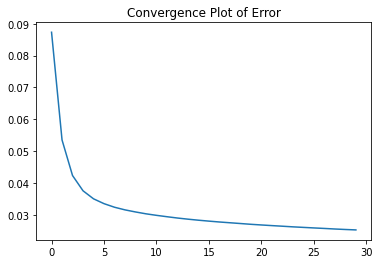

In [ ]:
plt.figure()
plt.plot(plot_loss)
plt.title('Convergence Plot of Error')

Text(0.5, 1.0, 'Convergence Plot of Error')

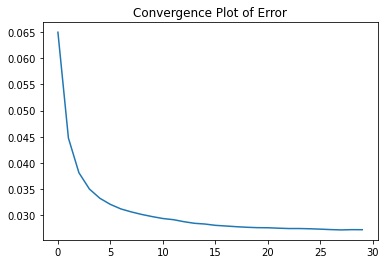

In [ ]:
plt.figure()
plt.plot(validation_loss)
plt.title('Convergence Plot of Error')

In [ ]:
test_data_set= func_data(test_Images_to_be_displayed)

In [ ]:
## Converting the data_set into the model input size

def data_conversion1(train_data_final2):
  loading_train_data1=[]
  for i in range(len(train_data_final2)):
    loading_train_data1.append(train_data_final2[i][0:8])
  return loading_train_data1

In [ ]:
test_data_set1=data_conversion1(test_data_set)

In [ ]:
test_data_set2=torch.FloatTensor(test_data_set1)

In [ ]:
## Patching the first 8 patches of first 200 images:
state_h1, state_c1 = model_lstm.init_state(test_data_set2)
with torch.no_grad():
  outputs,(state_h2,state_c2)= model_lstm(test_data_set2.float().cuda(),(state_h1.cuda(),state_c1.cuda()))

In [ ]:
outputs_from_8th_time_step=outputs[:,7,:]

In [ ]:
def final_func(outputs_from_8th_time_step1,model,state_h21,state_c21):
  new_output=[]
  k=0
  new_output.append(outputs_from_8th_time_step1.cpu().numpy())
  with torch.no_grad():
    for k in range(7):
      input=outputs_from_8th_time_step1.reshape(200,1,49)
      prev_state=(state_h21,state_c21)
      new_output1,(state_h21,state_c21)= model_lstm(input.float().cuda(),prev_state)

      outputs_from_8th_time_step1 =new_output1
      new_ouput2=torch.squeeze(new_output1)

      new_output.append(new_ouput2.cpu().numpy())
  return new_output

In [ ]:
final_output_10_16= np.array(final_func(outputs_from_8th_time_step,model_lstm,state_h2,state_c2))

In [ ]:
test_images_final= test_Images_to_be_displayed[:,0:14,:]

In [ ]:
df1=[]
for i in range (8):
  df=[]
  for j in range(200):
    df.append(final_output_10_16[i][j].reshape(7,7))
  
  df1.append(df)

In [ ]:
po=[]
for k in range(200):
  v1= np.hstack((df1[0][k],df1[1][k],df1[2][k],df1[3][k]))
  v2= np.hstack((df1[4][k],df1[5][k],df1[6][k],df1[7][k]))
  v3=np.vstack((v1,v2))
  po.append(v3)

In [ ]:
final_test_images34=[]

for l in range(200):
  hj=np.vstack((test_images_final[l],po[l]))
  final_test_images34.append(hj)

## Output Images Based on Regeneration

<function matplotlib.pyplot.show>

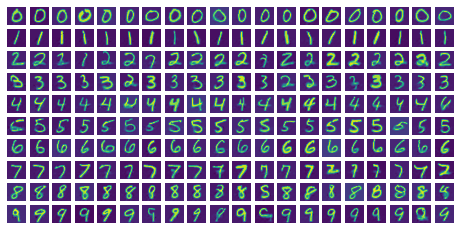

In [ ]:
n_images = 200
fig = plt.figure(figsize=(8,8))
for i in range(n_images):
  fig.add_subplot(n_images//10,20,i+1)
  plt.axis('off')
  plt.imshow( final_test_images34[i])
plt.show